In [ ]:
"""
@author: Ajay
"""

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import make_classification
from cf_matrix import make_confusion_matrix
from spiking_binary_classifier import *
from plot_metric.functions import MultiClassClassification, BinaryClassification

In [2]:
#fixing random state
random_state=1234

# Generate 2 class dataset
X, Y = make_classification(n_samples=10000, n_classes=2, weights=[1,1], random_state=1)
# split into train/test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# Load dataset (we just selected 4 classes of digits)
#X, Y = load_digits(n_class=4, return_X_y=True)

print(f'Predictors: {X}')

print(f'Outcome: {Y}')

print(f'Distribution of target:')
print(pd.value_counts(Y))

# Add noisy features to make the problem more harder
#random_state = np.random.RandomState(123)
#n_samples, n_features = X.shape
#X = np.c_[X, random_state.randn(n_samples, 1000 * n_features)]

## Spliting data into train and test sets.
X, X_test, y, y_test = train_test_split(X, Y, test_size=0.4,
                                        random_state=123)

## Spliting train data into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                                                      random_state=1)

print('Data shape:')
print('X_train: %s, X_valid: %s, X_test: %s \n' %(X_train.shape, X_valid.shape,
                                                  X_test.shape))

Predictors: [[-0.23629978 -1.05493612 -0.43290515 ... -0.3493208  -1.11850064
   0.3847425 ]
 [ 0.19173349 -2.3689596  -0.49565017 ...  0.18279077  0.21356147
   0.49222565]
 [ 0.26559616 -0.53611925 -0.14163292 ...  0.62926365  1.07755487
   0.94463163]
 ...
 [-0.69998136  1.32415374 -0.85002558 ... -0.22088742  2.72373949
  -0.48296092]
 [ 1.74253803  0.32763222 -0.43618563 ... -0.29079439  0.37285878
  -0.39378543]
 [-0.81545439  0.04712317 -0.63314742 ... -0.0127121   0.82512065
   1.30908699]]
Outcome: [1 0 1 ... 1 1 0]
Distribution of target:
1    5014
0    4986
dtype: int64
Data shape:
X_train: (4800, 20), X_valid: (1200, 20), X_test: (4000, 20) 



In [3]:
# Scale data to have mean '0' and variance '1' 
# which is importance for convergence of the neural network
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

X_train, y_train = np.array(X_train), np.array(y_train)

X_valid, y_valid = np.array(X_valid), np.array(y_valid)

X_test, y_test = np.array(X_test), np.array(y_test)   

In [4]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [5]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = trainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train))

## validation data

class valData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
val_data = valData(torch.FloatTensor(X_valid), 
                       torch.FloatTensor(y_valid))

## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = testData(torch.FloatTensor(X_test))

In [6]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [7]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(20, 64) 
        #self.layer_2 = nn.Linear(100, 1)
        self.layer_out = nn.Linear(64, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        #self.batchnorm2 = nn.BatchNorm1d(64)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        #x = self.relu(self.layer_2(x))
        #x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
#model = binaryClassification()
#model = SpikingNeuralNetwork(device, X_train.shape[1], hidden_dim_l1=64, hidden_dim_l2=64, n_time_steps=64, begin_eval=0)
model = SpikingNeuralNetwork(device, X_train.shape[1], n_time_steps=500, begin_eval=0)
model.to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

SpikingNeuralNetwork(
  (input_conversion): InputDataToSpikingPerceptronLayer()
  (layer1): SpikingNeuronLayer(
    (fc): Linear(in_features=20, out_features=64, bias=True)
  )
  (layer2): SpikingNeuronLayer(
    (fc): Linear(in_features=64, out_features=1, bias=True)
  )
  (output_conversion): OutputDataToSpikingPerceptronLayer()
)


In [16]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [17]:
model.train()
for e in range(1,EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 51.24757 | Acc: 70.747
Epoch 002: | Loss: 7.52399 | Acc: 90.813
Epoch 003: | Loss: 4.35771 | Acc: 94.200
Epoch 004: | Loss: 2.96351 | Acc: 95.587
Epoch 005: | Loss: 2.34597 | Acc: 96.387
Epoch 006: | Loss: 1.88235 | Acc: 96.907
Epoch 007: | Loss: 1.62627 | Acc: 97.400
Epoch 008: | Loss: 1.34612 | Acc: 97.613
Epoch 009: | Loss: 1.30753 | Acc: 97.773
Epoch 010: | Loss: 1.15006 | Acc: 97.987
Epoch 011: | Loss: 1.11126 | Acc: 97.653
Epoch 012: | Loss: 0.95166 | Acc: 98.120
Epoch 013: | Loss: 0.83601 | Acc: 98.227
Epoch 014: | Loss: 0.76746 | Acc: 98.107
Epoch 015: | Loss: 0.76187 | Acc: 98.093
Epoch 016: | Loss: 0.72128 | Acc: 98.213
Epoch 017: | Loss: 0.70757 | Acc: 98.173
Epoch 018: | Loss: 0.62441 | Acc: 98.160
Epoch 019: | Loss: 0.57398 | Acc: 98.333
Epoch 020: | Loss: 0.56046 | Acc: 98.467
Epoch 021: | Loss: 0.51255 | Acc: 98.267
Epoch 022: | Loss: 0.53363 | Acc: 98.227
Epoch 023: | Loss: 0.49538 | Acc: 98.440
Epoch 024: | Loss: 0.44534 | Acc: 98.373
Epoch 025: | Lo

In [18]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

[[1940   62]
 [  62 1936]]


'\n[[1963   39]\n [  47 1951]]\n \n[[1975   27]\n [  36 1962]]\n'

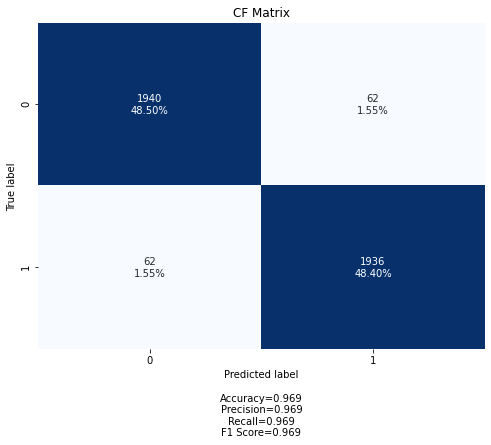

In [19]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_list)
print(cf_matrix)
make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=False, title='CF Matrix')
'''
[[1978   24]
 [ 622 1376]]
 
 [[1376  626]
 [  11 1987]]
 
 [[1972   30]
 [ 623 1375]]

'''
# NON-SPIKING NN
'''
[[1963   39]
 [  47 1951]]
 
[[1975   27]
 [  36 1962]]
'''

In [20]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2002
           1       0.97      0.97      0.97      1998

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



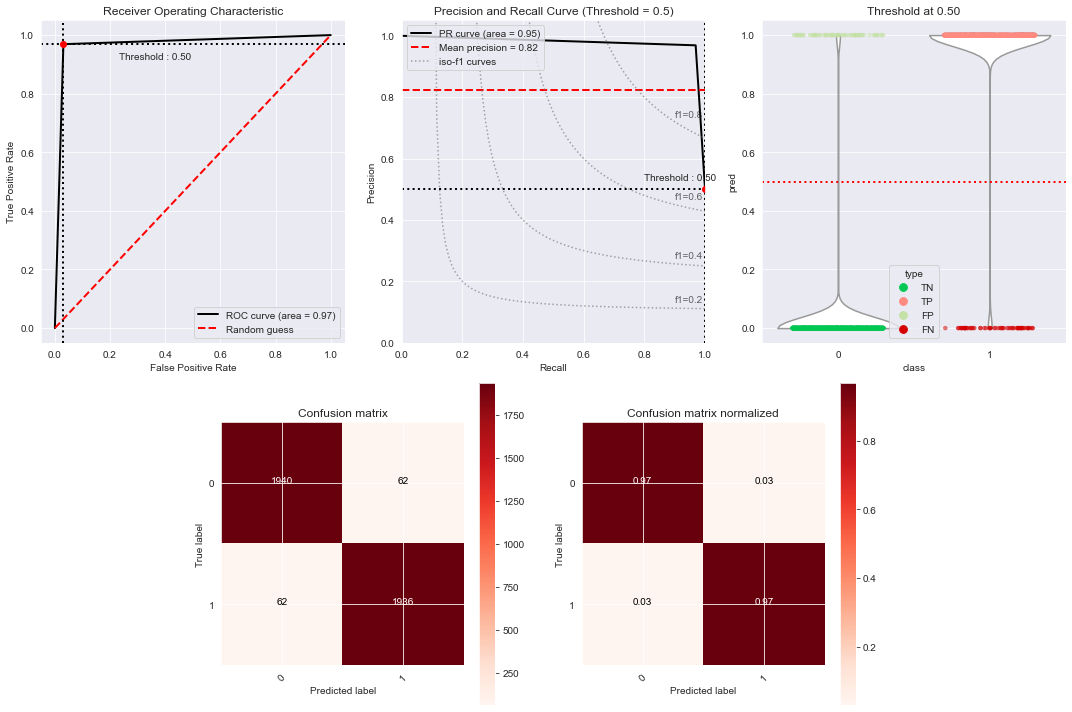

                   ________________________
                  |  Classification Report |
                   ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2002
           1       0.97      0.97      0.97      1998

    accuracy                           0.97      4000
   macro avg       0.97      0.97      0.97      4000
weighted avg       0.97      0.97      0.97      4000



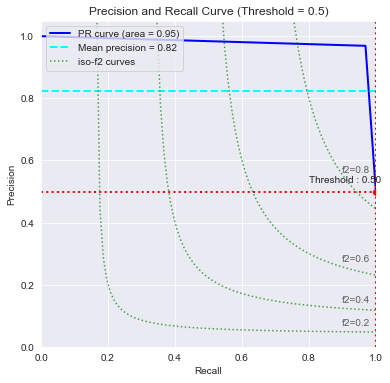

In [21]:
# report
# Visualisation of plots
bc = BinaryClassification(y_test, y_pred_list, labels=[0, 1])
# Figures
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
bc.plot_roc_curve()
plt.subplot2grid((2,6), (0,2), colspan=2)
bc.plot_precision_recall_curve()
plt.subplot2grid((2,6), (0,4), colspan=2)
bc.plot_class_distribution()
plt.subplot2grid((2,6), (1,1), colspan=2)
bc.plot_confusion_matrix()
plt.subplot2grid((2,6), (1,3), colspan=2)
bc.plot_confusion_matrix(normalize=True)

# Save figure
plt.savefig('../figures/images/example_binary_classification.png')

# Display Figure
plt.show()
plt.close()

# Full report of the classification
bc.print_report()

# Example custom param using dictionnary
param_pr_plot = {
    'c_pr_curve':'blue',
    'c_mean_prec':'cyan',
    'c_thresh_lines':'red',
    'c_f1_iso':'green',
    'beta': 2,
}

plt.figure(figsize=(6,6))
bc.plot_precision_recall_curve(**param_pr_plot)

# Save figure
plt.savefig('../figures/images/example_binary_class_PRCurve_custom.png')

# Display Figure
plt.show()
plt.close()